In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import gc
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error


1. Load and Inspect The Dataset

In [2]:
#load dataset
df = pd.read_csv("F:\Zindi\IBM\data\Data.csv",parse_dates=["date_time"])
df.head()

<>:2: SyntaxWarning: invalid escape sequence '\Z'
<>:2: SyntaxWarning: invalid escape sequence '\Z'
C:\Users\hp\AppData\Local\Temp\ipykernel_13112\1867439533.py:2: SyntaxWarning: invalid escape sequence '\Z'
  df = pd.read_csv("F:\Zindi\IBM\data\Data.csv",parse_dates=["date_time"])


,date_time,v_red,current,power_factor,kwh,Source,v_blue,v_yellow,consumer_device_9,consumer_device_x
0,2024-07-22 18:20:00,137.65,0.08,0.72,0.000661,consumer_device_10_data_user_1,NaN,NaN,0,10
1,2024-07-22 18:25:00,122.82,0.08,0.73,0.000598,consumer_device_10_data_user_1,NaN,NaN,0,10
2,2024-07-22 18:30:00,119.70,0.08,0.74,0.000591,consumer_device_10_data_user_1,NaN,NaN,0,10
3,2024-07-22 18:35:00,124.53,0.08,0.75,0.000623,consumer_device_10_data_user_1,NaN,NaN,0,10
4,2024-07-22 18:40:00,134.84,0.08,0.74,0.000665,consumer_device_10_data_user_1,NaN,NaN,0,10


In [3]:
# Display basic info
print(df.info())  # Check data types and missing values



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39147559 entries, 0 to 39147558
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   date_time          datetime64[ns]
 1   v_red              float64       
 2   current            float64       
 3   power_factor       float64       
 4   kwh                float64       
 5   Source             object        
 6   v_blue             float64       
 7   v_yellow           float64       
 8   consumer_device_9  int64         
 9   consumer_device_x  int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 2.9+ GB
None


In [4]:
print(df.describe())  # Summary statistics

                           date_time         v_red       current  \
count                       39147559  1.381927e+07  3.914756e+07   
mean   2024-03-26 01:42:08.256079872  2.175315e+01  2.014812e-01   
min              2023-06-03 12:25:00  0.000000e+00  0.000000e+00   
25%              2023-12-28 01:12:30  0.000000e+00  0.000000e+00   
50%              2024-03-28 09:35:00  0.000000e+00  0.000000e+00   
75%              2024-06-27 18:00:00  0.000000e+00  0.000000e+00   
max              2024-09-23 23:55:00  2.400000e+02  4.539000e+01   
std                              NaN  5.806591e+01  1.666040e+00   

       power_factor           kwh        v_blue      v_yellow  \
count  3.914756e+07  3.914756e+07  1.224839e+07  1.307990e+07   
mean   7.008604e-02  2.103631e-03  2.016875e+01  1.965710e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 

In [5]:
#check missing values
df.isnull().sum()

date_time                   0
v_red                25328292
current                     0
power_factor                0
kwh                         0
Source                      0
v_blue               26899165
v_yellow             26067661
consumer_device_9           0
consumer_device_x           0
dtype: int64

In [6]:
# Drop junk columns (adjust if the names differ slightly)
df = df.drop(columns=["consumer_device_9", "consumer_device_x"], errors="ignore")

In [7]:
# Drop rows where v_red is missing — assuming these rows are broken
df = df.dropna(subset=["v_red"])

In [9]:
# Re-check missing values
print(df.isnull().sum())

date_time              0
v_red                  0
current                0
power_factor           0
kwh                    0
Source                 0
v_blue          13819267
v_yellow        13819267
dtype: int64


Step 1: Label Phase Type
We'll use whether v_blue is missing to determine if a device is single-phase or three-phase.

In [10]:
# Label devices as single or three-phase
df["phase_type"] = df["v_blue"].isna().map({True: "single", False: "three"})


In [11]:
print(df["phase_type"].value_counts())


phase_type
single    13819267
Name: count, dtype: int64


Step 2: Extract Date for Daily Grouping

In [12]:
# Extract just the date (for daily grouping)
df["date"] = df["date_time"].dt.date


Step 3: Aggregate to Daily Metrics Per Device

In [13]:
daily_df = df.groupby(["Source", "date"]).agg({
    "kwh": "sum",
    "v_red": "mean",
    "v_blue": "mean",
    "v_yellow": "mean",
    "current": "mean",
    "power_factor": "mean",
    "phase_type": "first"
}).reset_index()


Step 4: Sort and Preview



In [14]:
# Optional: sort by date and Source for consistency
daily_df = daily_df.sort_values(by=["Source", "date"]).reset_index(drop=True)

# Preview the processed data
print(daily_df.head())


                           Source        date       kwh       v_red  v_blue  \
0  consumer_device_10_data_user_1  2024-07-22  0.024330   99.162941     NaN   
1  consumer_device_10_data_user_1  2024-07-23  0.103560  101.665556     NaN   
2  consumer_device_10_data_user_1  2024-07-24  0.137543  100.080938     NaN   
3  consumer_device_10_data_user_1  2024-07-25  0.121011  101.122604     NaN   
4  consumer_device_10_data_user_1  2024-07-26  0.000000   32.168472     NaN   

   v_yellow   current  power_factor phase_type  
0       NaN  0.079853      0.384118     single  
1       NaN  0.060486      0.342986     single  
2       NaN  0.074063      0.399896     single  
3       NaN  0.082743      0.356250     single  
4       NaN  0.000000      0.000000     single  


Climate Data

In [18]:
# Read the Excel file
climate_df = pd.read_excel(r"F:\Zindi\IBM\data\Kalam Climate Data.xlsx")

In [19]:
# Preview the data
print(climate_df.head())


            Date Time  Temperature (°C)  Dewpoint Temperature (°C)  \
0 2023-06-03 13:00:00          7.199731                  -2.448126   
1 2023-06-03 14:00:00          6.000620                  -2.597540   
2 2023-06-03 15:00:00          4.789972                  -2.696951   
3 2023-06-03 16:00:00          3.158746                  -2.879324   
4 2023-06-03 17:00:00          1.671426                  -3.255606   

   U Wind Component (m/s)  V Wind Component (m/s)  Total Precipitation (mm)  \
0               -0.034195                0.060989                  0.000377   
1               -0.080688                0.018585                  0.000398   
2                0.057449               -0.352020                  0.000418   
3                0.051529               -0.608948                  0.000420   
4                0.056137               -0.739838                  0.000420   

   Snowfall (mm)  Snow Cover (%)  
0            0.0       99.972656  
1            0.0       99.972656  

In [20]:
print(climate_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12228 entries, 0 to 12227
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date Time                  12228 non-null  datetime64[ns]
 1   Temperature (°C)           12228 non-null  float64       
 2   Dewpoint Temperature (°C)  12228 non-null  float64       
 3   U Wind Component (m/s)     12228 non-null  float64       
 4   V Wind Component (m/s)     12228 non-null  float64       
 5   Total Precipitation (mm)   12228 non-null  float64       
 6   Snowfall (mm)              12228 non-null  float64       
 7   Snow Cover (%)             12228 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 764.4 KB
None


Rename Columns for Simplicity

In [21]:
climate_df.columns = [
    "datetime", "temperature", "dew_point", "u_wind", "v_wind",
    "precipitation", "snowfall", "snow_cover"
]


Convert to Daily Averages (or Totals)

In [22]:
# Convert datetime column to pandas datetime
climate_df["datetime"] = pd.to_datetime(climate_df["datetime"])

In [23]:
# Extract just the date for grouping
climate_df["date"] = climate_df["datetime"].dt.date

In [24]:
# Daily aggregation
daily_climate = climate_df.groupby("date").agg({
    "temperature": "mean",
    "dew_point": "mean",
    "u_wind": "mean",
    "v_wind": "mean",
    "precipitation": "sum",  # usually makes sense to sum precip
    "snowfall": "sum",
    "snow_cover": "mean"
}).reset_index()

Merge With Your Daily Energy Data

In [25]:
merged_df = pd.merge(daily_df, daily_climate, on="date", how="left")


In [26]:
print(merged_df.head())


                           Source        date       kwh       v_red  v_blue  \
0  consumer_device_10_data_user_1  2024-07-22  0.024330   99.162941     NaN   
1  consumer_device_10_data_user_1  2024-07-23  0.103560  101.665556     NaN   
2  consumer_device_10_data_user_1  2024-07-24  0.137543  100.080938     NaN   
3  consumer_device_10_data_user_1  2024-07-25  0.121011  101.122604     NaN   
4  consumer_device_10_data_user_1  2024-07-26  0.000000   32.168472     NaN   

   v_yellow   current  power_factor phase_type  temperature  dew_point  \
0       NaN  0.079853      0.384118     single    14.719596   8.280669   
1       NaN  0.060486      0.342986     single    13.217268   9.862700   
2       NaN  0.074063      0.399896     single    12.462190   9.865658   
3       NaN  0.082743      0.356250     single    13.867551   8.973798   
4       NaN  0.000000      0.000000     single    15.572609   9.434734   

     u_wind    v_wind  precipitation  snowfall  snow_cover  
0  0.022655 -0.1049

In [27]:
print(merged_df.isnull().sum())

Source               0
date                 0
kwh                  0
v_red                0
v_blue           48155
v_yellow         48155
current              0
power_factor         0
phase_type           0
temperature          0
dew_point            0
u_wind               0
v_wind               0
precipitation        0
snowfall             0
snow_cover           0
dtype: int64


Basic Visualization

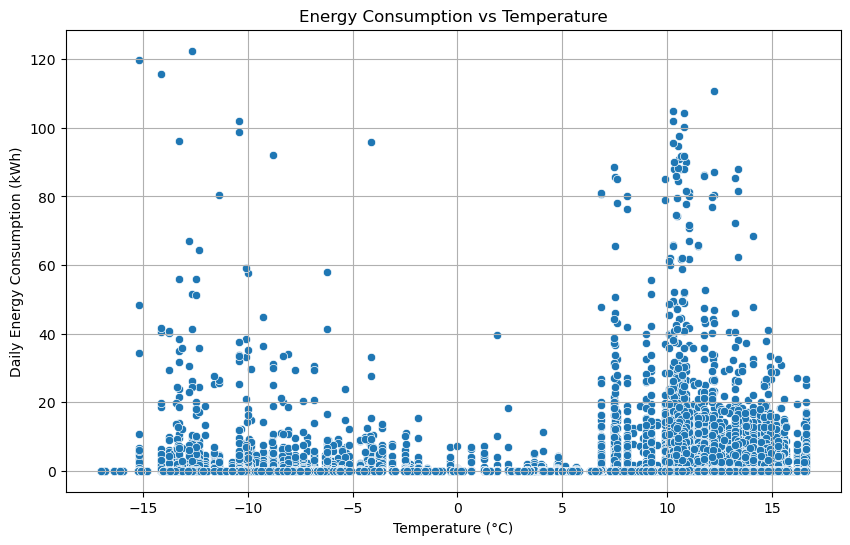

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Relationship between temperature and kWh
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x="temperature", y="kwh")
plt.title("Energy Consumption vs Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Daily Energy Consumption (kWh)")
plt.grid(True)
plt.show()


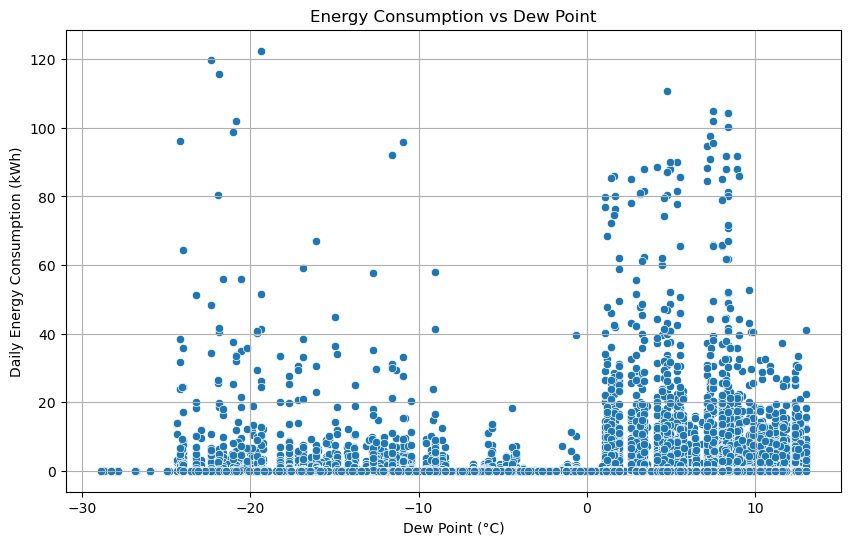

In [29]:
#Plot 1: dew_point vs kwh
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x="dew_point", y="kwh")
plt.title("Energy Consumption vs Dew Point")
plt.xlabel("Dew Point (°C)")
plt.ylabel("Daily Energy Consumption (kWh)")
plt.grid(True)
plt.show()


In [31]:
#Combined Wind Speed vs kwh
#calculate wind speed from the U & V components:
import numpy as np

merged_df["wind_speed"] = np.sqrt(merged_df["u_wind"]**2 + merged_df["v_wind"]**2)


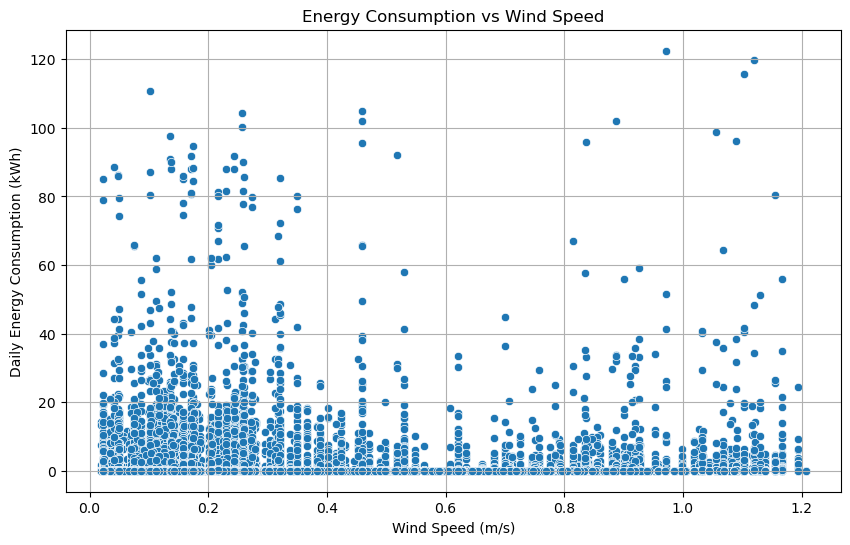

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x="wind_speed", y="kwh")
plt.title("Energy Consumption vs Wind Speed")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Daily Energy Consumption (kWh)")
plt.grid(True)
plt.show()


In [37]:
#Create Lag Features and Rolling Averages
#Lag features help capture recent trends, which models like XGBoost can pick up on.

# Sort by Source and date before creating lag features
merged_df = merged_df.sort_values(by=["Source", "date"])

# Add lag and rolling features for kWh
merged_df["kwh_lag1"] = merged_df.groupby("Source")["kwh"].shift(1)
merged_df["kwh_rolling3"] = merged_df.groupby("Source")["kwh"].rolling(3).mean().reset_index(0, drop=True)


In [39]:
# Define the features you want to model with
features = [
    "temperature", "dew_point", "precipitation", "snow_cover",
    "kwh_lag1", "kwh_rolling3"
]

# Drop only rows where any of these or target ('kwh') is missing
model_df = merged_df.dropna(subset=features + ["kwh"])

print("Cleaned dataset shape:", model_df.shape)


Cleaned dataset shape: (47743, 19)


In [35]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [41]:
X = model_df[features]
y = model_df["kwh"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Training set size: 38194, Test set size: 9549


In [42]:

# Initialize XGBoost Regressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1)

# Fit the model
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 0.1991595739300966


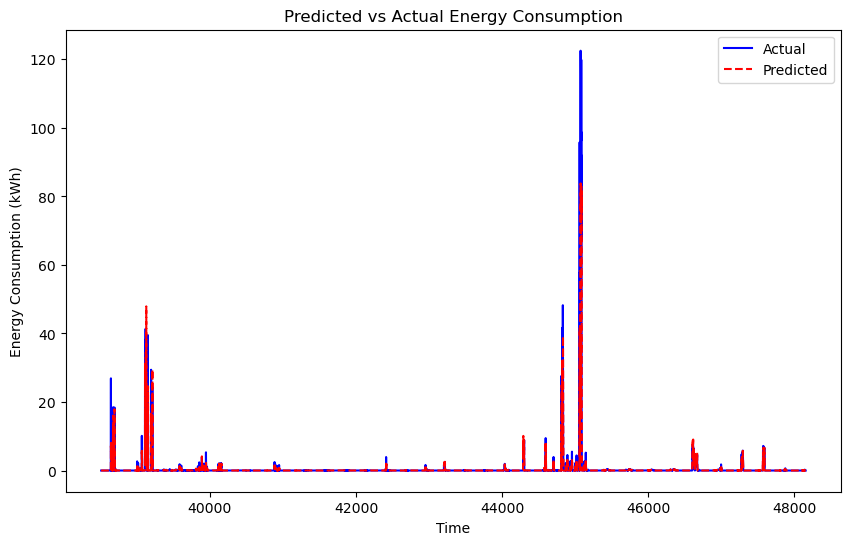

In [43]:
#Visualize predictions vs actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red", linestyle="--")
plt.title("Predicted vs Actual Energy Consumption")
plt.xlabel("Time")
plt.ylabel("Energy Consumption (kWh)")
plt.legend()
plt.show()


In [44]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 1.874659703447912


Submission File

In [46]:

# Create submission format
submission = pd.DataFrame({
    'ID': X_test.index,  # Assuming 'X_test' has time indices
    'kwh': y_pred
})

In [50]:
from datetime import datetime

# Assuming 'X_test.index' contains datetime info
submission['ID'] = submission['ID'].apply(
    lambda x: f"{x.strftime('%Y-%m-%d')}_consumer_device_{x[0]}_data_user_{x[1]}" if isinstance(x, datetime) else f"{x}_consumer_device_1_data_user_1"
)

# Save to CSV
submission.to_csv("submission.csv", index=False)
print("Submission file saved as 'submission.csv'")


Submission file saved as 'submission.csv'
